Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Rea Rustagi"
COLLABORATORS = "Victor Lue"

---

In [2]:
from __future__ import print_function
%matplotlib inline
%precision 16
import numpy
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import time

# HW 7:  ODE Methods for Stiff problems and Intro to Linear Algebra



## Question 1: Solver comparison for stiff solvers

The classic example of a stiff non-linear ODE is the Van der Pol oscillator

$$x^{\prime\prime} - \mu (1 - x^2) x^\prime + x = 0 \quad \quad \text{with} \quad \quad  x(0) = x_0, \quad x^\prime(0) = v_0$$

Which admits a single periodic limit cycle for any given value of $\mu$ and initial condition.

This problem is extremely stiff for large values of $\mu$ and will break most explicit ODE solvers due to stability issues.  

In addition,  this problem  also puts a strain on any **fixed time-step** integrator as there are large periods of slow growth punctuated by very rapid changes in time.  Thus maintaining accuracy for a non-adaptive code remains challenging.

This problem set will explore some of these numerical issues through a variety of sub-problems and emphasize the importance of stability, accuracy and adaptability.

**(a) Derivation and coding** [6 pts]: introduce the auxiliary variable $v=x^\prime$ and rewrite the problem as a 2-dimensional non-linear autonomous dynamical system 

$$\mathbf{u}^\prime = \mathbf{f}(\mathbf{u;\mu})$$

where
$$
    \mathbf{u} = \begin{bmatrix} x \\ v \\\end{bmatrix}, \quad \mathbf{f} = \begin{bmatrix} f_1(x,v) \\ f_2(x,v) \\\end{bmatrix}
$$

Using the auxiliary variable substitution $x^\prime = v$ we get the dynamical system:
$$
\begin{cases}
  x^\prime = v \\    
  v^\prime = \mu (1-x^2)v-x    
\end{cases}
$$

now write a short python function to return the righthand side $\mathbf{f}(t,\mathbf{u};\mu)$.  

While we are at it, write a routine to return  the jacobian of $\mathbf{f}$,  $\mathcal{J}(t,\mathbf{u};\mu)$ whose components are defined as

$$
    \mathcal{J}_{i,j} = \frac{\partial f_i}{\partial u_j}
$$

(you would need this if you were going to use Newtons method to solve a BDF scheme)

In [3]:
#  Add code to evaluate the RHS of the vanderpol equation
def fvanderpol(t,u,mu):
    """ RHS of vanderpol equation (you can improve this docstring)            
    """
    rhs = numpy.array([u[1], mu * (1.0 - u[0]**2) * u[1] - u[0]])
    return rhs
    
# the jacobian of the right hand side
def jvanderpol(t, u, mu):
    """ Jacobian of RHS of vanderpol equation"""
    
    jac = numpy.array([[0, 1], 
                       [-2.*mu*u[0]*u[1]-1, mu*(1-u[0]**2)]])
    return jac

In [4]:
t=0. 
u = numpy.array([1.5, 2.])
mu = 0.
# test f
answer = numpy.array([2., -1.5])
numpy.testing.assert_allclose(answer,fvanderpol(t, u, mu))
# test jacobian
answer = numpy.array([[0., 1.], [-1., 0]])
numpy.testing.assert_allclose(answer,jvanderpol(t, u, mu))


mu = 10.
#  test f
answer = numpy.array([  2. , -26.5])
numpy.testing.assert_allclose(answer,fvanderpol(t, u, mu))
answer = numpy.array([[  0.,    1. ], [-61.,  -12.5]])
numpy.testing.assert_allclose(answer,jvanderpol(t, u, mu))
print('success')

success


Now Explore solving this problem using `scipy.integrate.solve_ivp` for  a range of $\mu$ and different methods

For this problem we will integrate the vanderpol equations starting at initial condition $\mathbf{u}_0=[1.,0]$ for the time interval $t\in[0,100]$ and compare the behavior of four different methods 

* Embedded RK method RK45
* BDF
* Radau 
* any other method supported by solve_ivp

for 11 values of the damping parameter $\mu$ in the range $[1,100]$

**(b)** [6 pts] 

Make three plots that compare  your 4 methods as a function of $\mu$ in terms of

1. the number of *time steps* required to solve this problem 
2. the number of *function evaluations* required (see below) 
3. the elapsed run time for each method in seconds (see below)

**Some hints:**
* Most of the pieces of this are in the notebook. 
* a log scale for the y axis might be useful
* use a lambda function to handle the extra argument $\mu$.  I can't seem to get `solve_ivp` to work in a sensible way with the args argument (unless you do something wierd like `args=([mu])` but let me know if you find a clean fix)
* Look at the documentation for solve_ivp to figure out how to get the number of function valuations
* To calculate the run time in python 3 you can use something like

```python
import time
tic = time.perf_counter()
<do something>
toc = time.perf_counter()
elapsed_time = toc -tic
```

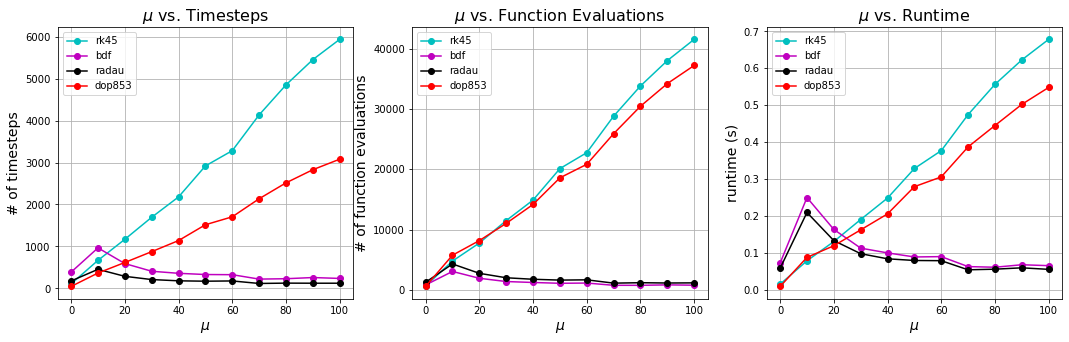

In [5]:
t_span = (0., 100.)
u0 = [1., 0.]
mu_vals = numpy.linspace(0, 100, 11)
f = lambda t, u, mu : fvanderpol(t, u, mu) 

fig = plt.figure(figsize=(18, 5))

rk45_feat = {'timesteps': [], 'evals': [], 'runtime': []}
bdf_feat = {'timesteps': [], 'evals': [], 'runtime': []}
rad_feat = {'timesteps': [], 'evals': [], 'runtime': []}
dop_feat = {'timesteps': [], 'evals': [], 'runtime': []}

for m in mu_vals:
    
    tic = time.perf_counter()
    sol_rk45 = solve_ivp(f, t_span, u0, method='RK45',args=([m]),rtol=1.e-3,atol=1.e-6)
    toc = time.perf_counter()
    rk45_feat['runtime'].append(toc - tic)
    rk45_feat['timesteps'].append(len(sol_rk45.t))
    rk45_feat['evals'].append(sol_rk45.nfev)
    
    tic = time.perf_counter()
    sol_bdf = solve_ivp(f, t_span, u0, method='BDF',args=([m]),rtol=1.e-3,atol=1.e-6)
    toc = time.perf_counter()
    bdf_feat['runtime'].append(toc - tic)
    bdf_feat['timesteps'].append(len(sol_bdf.t))
    bdf_feat['evals'].append(sol_bdf.nfev)
    
    tic = time.perf_counter()
    sol_rad = solve_ivp(f, t_span, u0, method='Radau',args=([m]),rtol=1.e-3,atol=1.e-6)
    toc = time.perf_counter()
    rad_feat['runtime'].append(toc - tic)
    rad_feat['timesteps'].append(len(sol_rad.t))
    rad_feat['evals'].append(sol_rad.nfev)
    
    tic = time.perf_counter()
    sol_dop = solve_ivp(f, t_span, u0, method='DOP853',args=([m]),rtol=1.e-3,atol=1.e-6)
    toc = time.perf_counter()
    dop_feat['runtime'].append(toc - tic)
    dop_feat['timesteps'].append(len(sol_dop.t))
    dop_feat['evals'].append(sol_dop.nfev)
    
    
# time steps
axes = fig.add_subplot(1, 3, 1)

axes.plot(mu_vals, rk45_feat['timesteps'], 'co-', label = 'rk45')
axes.plot(mu_vals, bdf_feat['timesteps'], 'mo-', label = 'bdf')
axes.plot(mu_vals, rad_feat['timesteps'], 'ko-', label = 'radau')
axes.plot(mu_vals, dop_feat['timesteps'], 'ro-', label = 'dop853')

axes.grid()
axes.set_xlabel('$\mu$', fontsize=14)
axes.set_ylabel('# of timesteps', fontsize=14)
axes.set_title('$\mu$ vs. Timesteps', fontsize=16)
axes.legend(loc='best',fontsize=10)

# function evals
axes = fig.add_subplot(1, 3, 2)

axes.plot(mu_vals, rk45_feat['evals'], 'co-', label = 'rk45')
axes.plot(mu_vals, bdf_feat['evals'], 'mo-', label = 'bdf')
axes.plot(mu_vals, rad_feat['evals'], 'ko-', label = 'radau')
axes.plot(mu_vals, dop_feat['evals'], 'ro-', label = 'dop853')

axes.grid()
axes.set_xlabel('$\mu$', fontsize=14)
axes.set_ylabel('# of function evaluations', fontsize=14)
axes.set_title('$\mu$ vs. Function Evaluations', fontsize=16)
axes.legend(loc='best',fontsize=10)

# runtime
axes = fig.add_subplot(1, 3, 3)

axes.plot(mu_vals, rk45_feat['runtime'], 'co-', label = 'rk45')
axes.plot(mu_vals, bdf_feat['runtime'], 'mo-', label = 'bdf')
axes.plot(mu_vals, rad_feat['runtime'], 'ko-', label = 'radau')
axes.plot(mu_vals, dop_feat['runtime'], 'ro-', label = 'dop853')

axes.grid()
axes.set_xlabel('$\mu$', fontsize=14)
axes.set_ylabel('runtime (s)', fontsize=14)
axes.set_title('$\mu$ vs. Runtime', fontsize=16)
axes.legend(loc='best',fontsize=10)

**(c)** [4 pts] Comment on your results here (**Hint** it might be useful to actually plot the behavior of the solution (or look at the notes) to understand your graphs)

BDF and Radau seem to perform best suited to solve the Van Del Pol Oscillator IVP. This makes sense because these two methods work best on stiff equations. RK45 and DOP853 performance worsens with increasing $\mu$, which makes sense because when $\mu$ is high, the system is increasingly nonlinear as damping increases. Thus, these two methods become even worse suited to solve the IVP, which is indicated by how expensive they get. 

### Project suggestion  Roll your own BDF-2 scheme using Newton's method

A more challenging problem is to write your own  BDF-2 scheme that uses Newton's method to solve the non-linear system of equations that arises at each time step.  Some things you should consider

1. Implement and test a routine for Newton's method
2. Implement a *fixed* time step BDF-2 scheme and test it against `solve_ivp` for the vanderpol oscillator. Some Hints:
    * you will need that jacobian here
    * you will need a way to get started (e.g. a BDF-1 scheme for the first step)
    * you will need to be able to handle exceptions from the Newton solver
3. For vanderpol, at least, you will find that to be efficient you will need both L-stability and adaptivity.  Consider how to use interpolation to make an adaptive BDF-23 scheme that compares the solution from a BDF-2 step with a BDF-3 step to control the time step (this is challenging).  Again, test your scheme against `solve_ivp`


# Linear Algebra: Part 1

## Question 2: Matrix Norms and Condition Numbers

Consider the Matrices

$$
    A = \begin{bmatrix} 1 & 1 \\
                        1 & a \\
         \end{bmatrix} \quad\quad
     A^{-1} = \frac{1}{a-1}\begin{bmatrix} a & -1 \\
                        -1 & 1 \\
         \end{bmatrix} 
$$
where $a\in\mathbb{R}$

**(a)** [6] Analytically calculate, as a function of $a$

* the induced $p$-norm $||A||_p$ 
* the $p$ condition number $\kappa_p(A) =||A||_p||A^{-1}||_p$ 

consider  $p=1,2,\infty$

(hint: for a symmetric matrix, the singular values are equal to the absolute value of the eigenvalues of $A$ (sorted from largest to smallest))

$||A||_1$ and $||A||_\infty$ are fairly straightfoward to calculate directly from $A$:
$$
||A||_1 = max(1 + 1, 1 + |a|) = max(2, 1 + |a|) = 1 + |a|\text{ if } |a|>1
$$
The 1-norm is the maximum absolute column sum of the matrix. 
$$
||A||_\infty = max(1 + 1, 1 + |a|) = max(2, 1 + |a|) = 1 + |a| \text{ if } |a|>1
$$
The $\infty$-norm is the maximum absolute row sum of the matrix.
$\newline$ To find the 2-norm, we will first calculate the singular values (which are the same as the absolute values of the eigenvalues) of A:
$$
\lambda_1 = \frac{1}{2}(-\sqrt{a^2-2a+5}+a+1)
\newline \lambda_2 = \frac{1}{2}(\sqrt{a^2-2a+5}+a+1)
$$
Therefore, the singular values are:
$$
\sigma_1 = |\frac{1}{2}(-\sqrt{a^2-2a+5}+a+1)|
\newline \sigma_2 = |\frac{1}{2}(\sqrt{a^2-2a+5}+a+1)|
$$
Then,
$$
||A||_2 = max(\sigma_1, \sigma_2) = |\frac{1}{2}(\sqrt{a^2-2a+5}+a+1)| \text{ if } a>1
$$
Next we will calculate the condition numbers (assuming $a > 1$):
$$\kappa_1(A) =||A||_1||A^{-1}||_1 = 1 + |a|$$
$$\kappa_\infty(A) =||A||_1||A^{-1}||_1 = 1 + |a|$$
$$\kappa_2(A) =||A||_1||A^{-1}||_1 = \frac{1}{2}(\sqrt{a^2-2a+5}+a+1) * \frac{\sqrt{a^2-2a+5}+a+1}{2(a-1)}
\newline = \frac{(\sqrt{a^2-2a+5}+a+1)^2}{4(a-1)}$$

**(b)** [6] write two short python routine that returns $||A||_p$, and $\kappa_p(A)$ for the matrices in part (a). Again, just consider $p=1,2,\infty$) and raise a ValueError if $p$ is any other value.

In [6]:
def mypnorm(a, p):
    """
    return ||A||_p for A = [[ 1, 1],
                            [ 1, a]]
                            
    for p = 1, 2, or numpy.infty
    
    parameters:
    -----------
    
    a: scalar 
        value of a
    p: scalar
        1, 2 or np.infty
    returns:
    --------
    pnorm(a)
    
    raises:
    --------
    ValueError:  if p is not in [ 1, 2, numpy.infty]
    """
    
    matrix_a = numpy.array([[1,1],
                           [1,a]])
    n, m = matrix_a.shape
    u, s, v = numpy.linalg.svd(matrix_a)
    
    if p in [ 1, 2, numpy.infty]:
        if p == 1:
            col_sums = []
            for i in numpy.arange(m):
                v = numpy.sum(numpy.abs(matrix_a[:, i]))
                col_sums.append(v)
            pnorm = numpy.max(col_sums)
        elif p == numpy.infty:
            row_sums = []
            for i in numpy.arange(n):
                v = numpy.sum(numpy.absolute(matrix_a[i, :]))
                row_sums.append(v)
            pnorm = numpy.max(row_sums)
        else:
            pnorm = max(s)
    else:
        raise ValueError('Invalid value entered for p. Try again.')
        
    return pnorm
    
def mycond(a, p):
    """
    return k_p(A) for A = [[ 1, 1],
                            [ 1, a]]
                            
    for p = 1, 2, or numpy.infty
    
    parameters:
    -----------
    
    a: scalar 
        value of a
    p: scalar
        1, 2 or np.infty
    returns:
    --------
    cond(a)
    
    raises:
    --------
    ValueError:  if p is not in [ 1, 2, numpy.infty]
    
    """
    matrix_a = numpy.array([[1, 1], 
                            [1, a]])
    u, s, v = numpy.linalg.svd(matrix_a)
    
    a_inv = (1/(a - 1))*numpy.array([[a, -1], [-1, 1]])
    
    if p in [ 1, 2, numpy.infty]:
        if p == 2:
            cond = max(s) / min(s) 
        elif p == 1:
            c1 = numpy.max(numpy.sum(numpy.abs(matrix_a), axis=0))
            c2 = numpy.max(numpy.sum(numpy.abs(a_inv), axis=0))
            cond = c1 * c2   
        else:
            c1 = numpy.max(numpy.sum(numpy.abs(matrix_a), axis=0))
            c2 = numpy.max(numpy.sum(numpy.abs(a_inv), axis=0))
            cond = c1 * c2 
    else:
        raise ValueError('Invalid value entered for p. Try again.')
    
    return cond

In [7]:
A = lambda a: numpy.array([ [ 1, 1], [1, a]])
aa = numpy.array([ -2, 0, 1.0001, 2])


for p in [ 1, 2, numpy.infty]:
    normp = [ mypnorm(a, p) for a in aa]
    test = [ numpy.linalg.norm(A(a), ord=p) for a in aa]    
    print('||A||_{} = {}'.format(p, normp))
    numpy.testing.assert_allclose(normp,test)
print('Successful Norm test')

for p in [ 1, 2, numpy.infty]:
    condp = [ mycond(a, p) for a in aa]
    test = [ numpy.linalg.cond(A(a), p) for a in aa]    
    print('k(A)_{} = {}'.format(p, condp))
    numpy.testing.assert_allclose(condp,test)
print('Successful condition number test')

# test the exception
try:
    mypnorm(0.,4)
except ValueError as err:
    print('Success: you caught the ValueError')
else:
    assert False, 'whoops, missed the exception'


||A||_1 = [3.0, 2.0, 2.0000999999999998, 3.0]
||A||_2 = [2.302775637731995, 1.618033988749895, 2.0000500012499995, 2.618033988749895]
||A||_inf = [3.0, 2.0, 2.0000999999999998, 3.0]
Successful Norm test
k(A)_1 = [3.0, 4.0, 40004.0001000044, 9.0]
k(A)_2 = [1.7675918792439984, 2.6180339887498953, 40002.00007491187, 6.854101966249685]
k(A)_inf = [3.0, 4.0, 40004.0001000044, 9.0]
Successful condition number test
Success: you caught the ValueError


 **(c)** [4] Make a plot comparing $\log(\kappa(A))$ vs $a$ for the different matrix norms over the range $a\in[-15,15]$. (you can check it by plotting `numpy.linalg.cond(A, ord)` as well. As always, make it pretty.

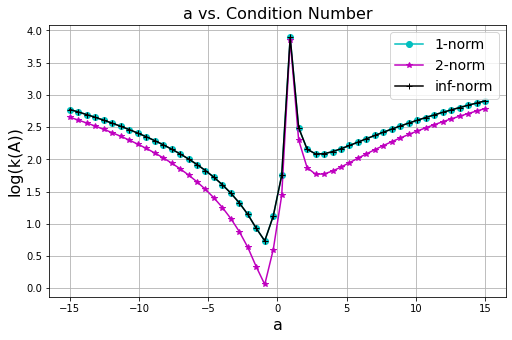

In [8]:
A = lambda a: numpy.array([[ 1, 1], [1, a]])
a_range = numpy.linspace(-15, 15)

cond_1 = [mycond(a, 1) for a in a_range]
cond_2 = [mycond(a, 2) for a in a_range]
cond_inf = [mycond(a, numpy.infty) for a in a_range]

fig = plt.figure(figsize=(18, 5))
axes = fig.add_subplot(1, 2, 1)
axes.plot(a_range, numpy.log(cond_1), 'co-', label = '1-norm')
axes.plot(a_range, numpy.log(cond_2), 'm*-', label = '2-norm')
axes.plot(a_range, numpy.log(cond_inf), 'k+-', label = 'inf-norm')
axes.set_xlabel('a', fontsize=16)
axes.set_ylabel('log(k(A))', fontsize=16)
axes.set_title('a vs. Condition Number', fontsize=16)
axes.legend(loc='best',fontsize=14)
axes.grid()

**(d)** [8] Given your plot comment on the following:
* What value of $a$ gives the best conditioned matrix.  Why?
* What value of $a$ gives the least well-condition matrix.  Why?
* Does it matter which norm we measure the condition number in?
* What value of $a$ gives the best conditioned matrix for $a>1$
 

Matrices with values of $a$ near -1 seem to be the best conditioned as the value of $log(k(A))$ approaches 1. I suspect this is because the matrix inverse can be computed computationally with great accuracy. 

Values of $a$ at 1 and at high positive or negative numbers produce ill-posed matrices. These matrices are almost singular, so their solutions are prone to large numerical errors. 

No, it seems that the norms for $p = 1, 2, \infty$ relay the same trends. 

For $a>1$, the best conditioned matrices seem to be the matrices where $a$ is around 2.5-3. 

#### **(e)** [6] The Geometry of matrix Norms

Let us explore the geometrical relationship implied by the induce matrix $p$-norm which can be viewed as a measure of how much the $A\mathbf{x}$ distorts the 'unit-ball' 

$$\{ \mathbf{x}\in\mathbb{R}^n:   \forall\, ||\mathbf{x}||_p=1\}$$

I will provide a routine to plot the unit ball and the image of $A$ acting on the unit ball here (modified from some cool routines by Kyle Mandli).  The following cell will import it and demonstrate how it's called

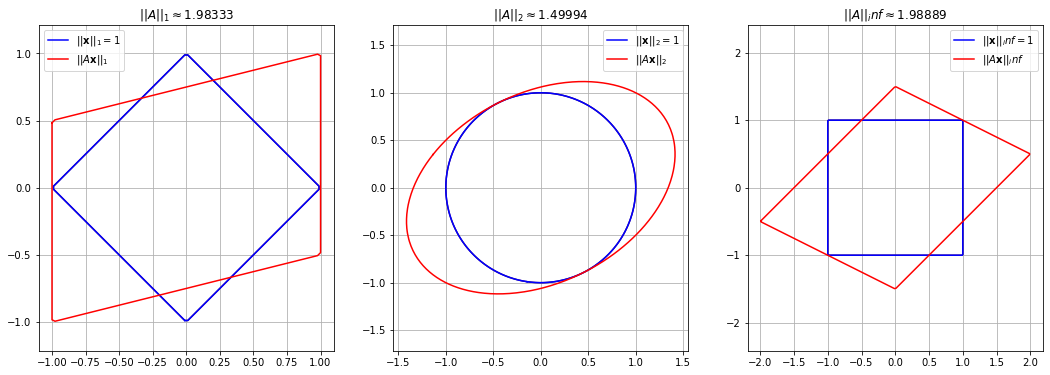

In [9]:
from unit_ball import unit_ball_image

# an Example comparing the behavior of the 1-norm, 2-norm and inf-norm
a=-0.5
fig = plt.figure(figsize=(18,6))
axes = fig.add_subplot(1,3,1, aspect='equal', adjustable='datalim')
max_norm = unit_ball_image(axes, A(a), 1)
axes = fig.add_subplot(1,3,2, aspect='equal', adjustable='datalim')
max_norm = unit_ball_image(axes, A(a), 2)
axes = fig.add_subplot(1,3,3, aspect='equal', adjustable='datalim')
max_norm = unit_ball_image(axes, A(a), numpy.inf)

plt.show()


Use this routine to make a figure comparing $||A(a)||_p$ and $||A^{-1}(a)||_p$ for $p=1,2,\infty$ and
* the best conditioned value of $a$
* a=1.08 (or as close to singular as you want to go). Can you explain why all the norms agree as $a\rightarrow1$?
* the best conditioned value of $a>1$

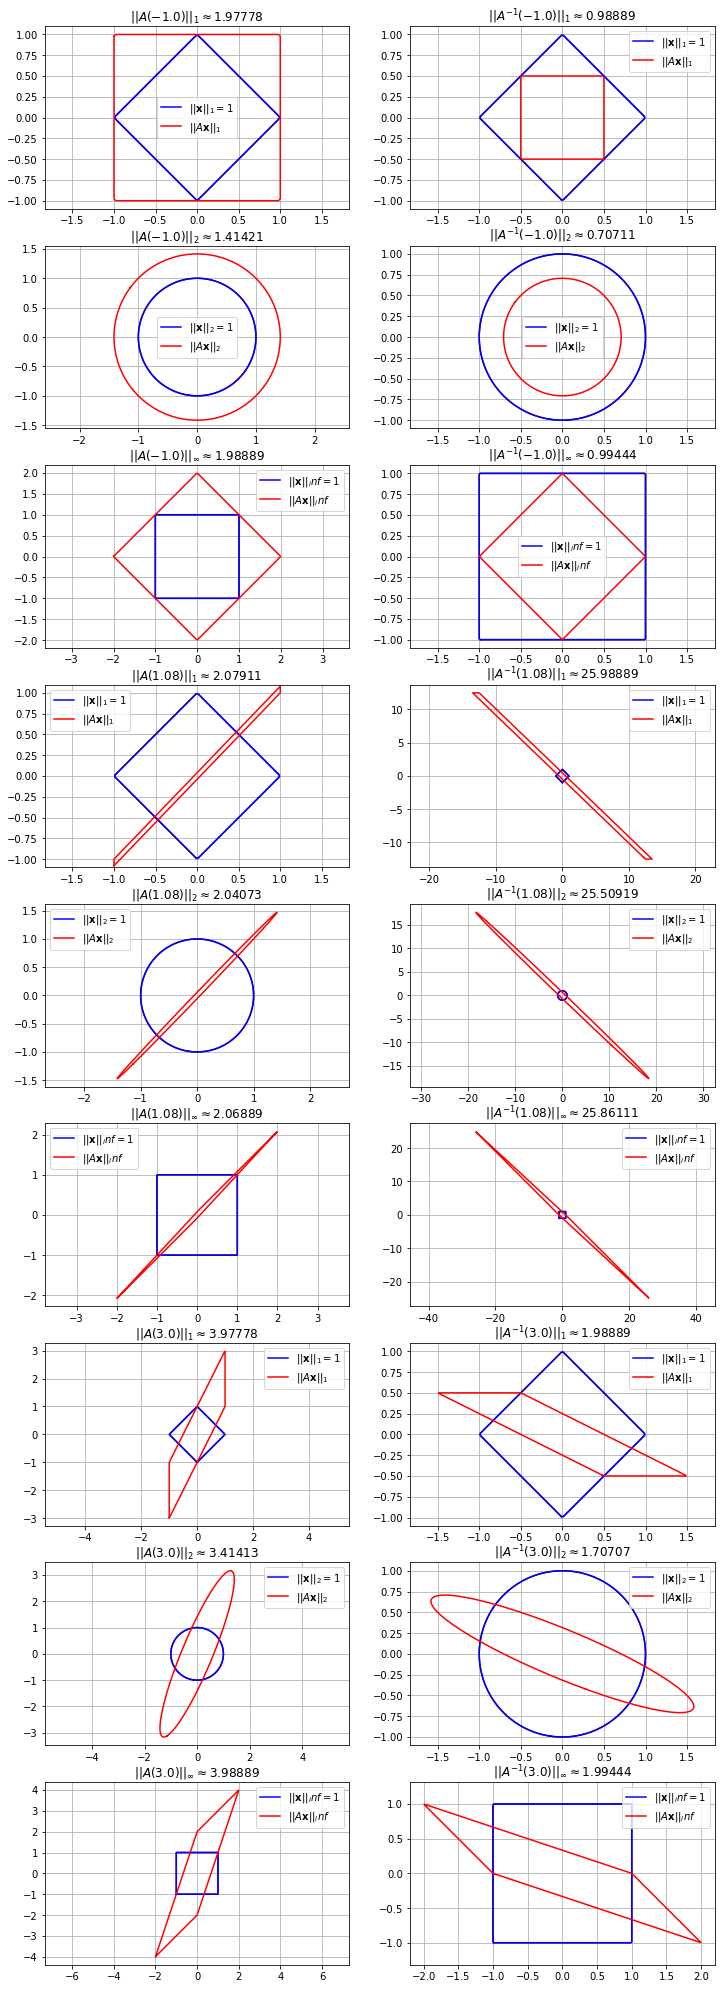

In [10]:
pa = [1, 2, numpy.inf]
aa = [-1., 1.08, 3.]
A_a = lambda a: numpy.array([[a, -1], [-1, 1]])/(a - 1)

fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2)
fig.set_figheight(fig.get_figheight() * 18)

i = 1
for a in aa:
    for p in pa:
        axes = fig.add_subplot(18,2,i, aspect='equal', adjustable='datalim')
        max_norm = unit_ball_image(axes, A(a), p, title=False)
        axes.set_title('$||A({})||_{}\\approx{:3.5f}$'.format(a, p, max_norm))
        if p == numpy.infty:
            axes.set_title('$||A({})||_\\infty\\approx{:3.5f}$'.format(a, max_norm))
        else:    
            axes.set_title('$||A({})||_{}\\approx{:3.5f}$'.format(a, p, max_norm))
        axes = fig.add_subplot(18,2,i+1, aspect='equal', adjustable='datalim')
        max_norm = unit_ball_image(axes, A_a(a), p, title=False)
        if p == numpy.infty:
            axes.set_title('$||A^{{-1}}({})||_\\infty\\approx{:3.5f}$'.format(a, max_norm))
        else:    
            axes.set_title('$||A^{{-1}}({})||_{}\\approx{:3.5f}$'.format(a, p, max_norm))
        i += 2

plt.show()